In [ ]:
# Install the InfluxDB Python client library
!pip install influxdb-client pandas

# Install Plotly for interactive charting (optional)
!pip install plotly

# **1. Send data up InfluxDB Cloud:**

In [ ]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS
import pandas as pd
import time
from datetime import datetime
import random

# --- InfluxDB Configuration ---
# Replace with your actual configuration
INFLUX_URL = "https://us-east-1-1.aws.cloud2.influxdata.com"
INFLUX_TOKEN = "hRguq4m3jV2rpfZKrI4hEEtzDrT2Xp2q7xo8M46f363btjhSTB_Q7jpThKtXwf-4X4t6aC8zWkZzFMISf3jifw=="
INFLUX_ORG = "University of Information Technology - UIT"
INFLUX_BUCKET = "TSBD"

# --- Initialize InfluxDB Client ---
client = influxdb_client.InfluxDBClient(
    url=INFLUX_URL,
    token=INFLUX_TOKEN,
    org=INFLUX_ORG
)

# --- Initialize Write API ---
write_api = client.write_api(write_options=SYNCHRONOUS)

# --- Simulate and Send Sensor Data ---
measurement = "sensor_data"
location_tag = "colab_room_1"

print("Starting to send data...")

for i in range(10):  # Send 10 data points
    temperature = random.uniform(20.0, 30.0)  # Random temperature
    humidity = random.uniform(40.0, 60.0)     # Random humidity

    # Create a data point
    point = (
        influxdb_client.Point(measurement)
        .tag("location", location_tag)
        .field("temperature", temperature)
        .field("humidity", humidity)
        .time(datetime.utcnow())  # Use current UTC time
    )

    # Write the data point to InfluxDB
    write_api.write(bucket=INFLUX_BUCKET, org=INFLUX_ORG, record=point)

    print(f"Sent: Temp={temperature:.2f}°C, Humidity={humidity:.2f}%")
    time.sleep(2)  # Wait 2 seconds between each entry

print("Data sending complete!")

# Close the client when done
client.close()


Starting to send data...
Sent: Temp=27.87°C, Humidity=43.14%
Sent: Temp=21.32°C, Humidity=40.03%
Sent: Temp=24.03°C, Humidity=47.10%
Sent: Temp=21.43°C, Humidity=52.31%
Sent: Temp=27.57°C, Humidity=57.86%
Sent: Temp=24.35°C, Humidity=50.82%
Sent: Temp=28.58°C, Humidity=50.07%
Sent: Temp=23.35°C, Humidity=48.24%
Sent: Temp=25.46°C, Humidity=57.89%
Sent: Temp=29.22°C, Humidity=57.46%
Data sending complete!


# **2. Query data from InfluxDB Cloud**

In [ ]:
import influxdb_client
import pandas as pd

# --- InfluxDB Configuration (Same as before) ---
INFLUX_URL = "https://us-east-1-1.aws.cloud2.influxdata.com"
INFLUX_TOKEN = "hRguq4m3jV2rpfZKrI4hEEtzDrT2Xp2q7xo8M46f363btjhSTB_Q7jpThKtXwf-4X4t6aC8zWkZzFMISf3jifw=="
INFLUX_ORG = "University of Information Technology - UIT"
INFLUX_BUCKET = "TSBD"

# --- Initialize InfluxDB Client ---
client = influxdb_client.InfluxDBClient(
    url=INFLUX_URL,
    token=INFLUX_TOKEN,
    org=INFLUX_ORG
)

# --- Initialize Query API ---
query_api = client.query_api()

# --- Create Flux Query ---
# Retrieve data from the last 1 hour from the specified bucket and measurement
flux_query = f'''
from(bucket: "{INFLUX_BUCKET}")
  |> range(start: -1h)
  |> filter(fn: (r) => r["_measurement"] == "sensor_data")
  |> filter(fn: (r) => r["location"] == "colab_room_1")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
'''

print("Querying data...")

# --- Execute query and convert result to Pandas DataFrame ---
result_df = query_api.query_data_frame(org=INFLUX_ORG, query=flux_query)

print("Query completed!")

# --- Display the data ---
if not result_df.empty:
    # Select and rename required columns
    result_df = result_df[['_time', 'temperature', 'humidity']]
    result_df = result_df.rename(columns={'_time': 'Time'})
    # Set 'Time' as index
    result_df['Time'] = pd.to_datetime(result_df['Time'])
    result_df.set_index('Time', inplace=True)
    print("\nRetrieved data:")
    print(result_df)
else:
    print("\nNo data found. Please check your bucket, measurement, tag, or time range.")

# Close client connection
client.close()


Querying data...
Query completed!

Retrieved data:
                                  temperature   humidity
Time                                                    
2025-05-26 13:00:31.697940+00:00    27.867648  43.137744
2025-05-26 13:00:33.824363+00:00    21.315555  40.029952
2025-05-26 13:00:35.870918+00:00    24.030109  47.104996
2025-05-26 13:00:37.913605+00:00    21.428519  52.312080
2025-05-26 13:00:39.965050+00:00    27.567237  57.856769
2025-05-26 13:00:42.009900+00:00    24.348813  50.818573
2025-05-26 13:00:44.054494+00:00    28.576302  50.069520
2025-05-26 13:00:46.100634+00:00    23.353530  48.239963
2025-05-26 13:00:48.144194+00:00    25.457128  57.885206
2025-05-26 13:00:50.189884+00:00    29.216205  57.458465


# **3. Plotting data**

## **3.1 Using Matplotlib**

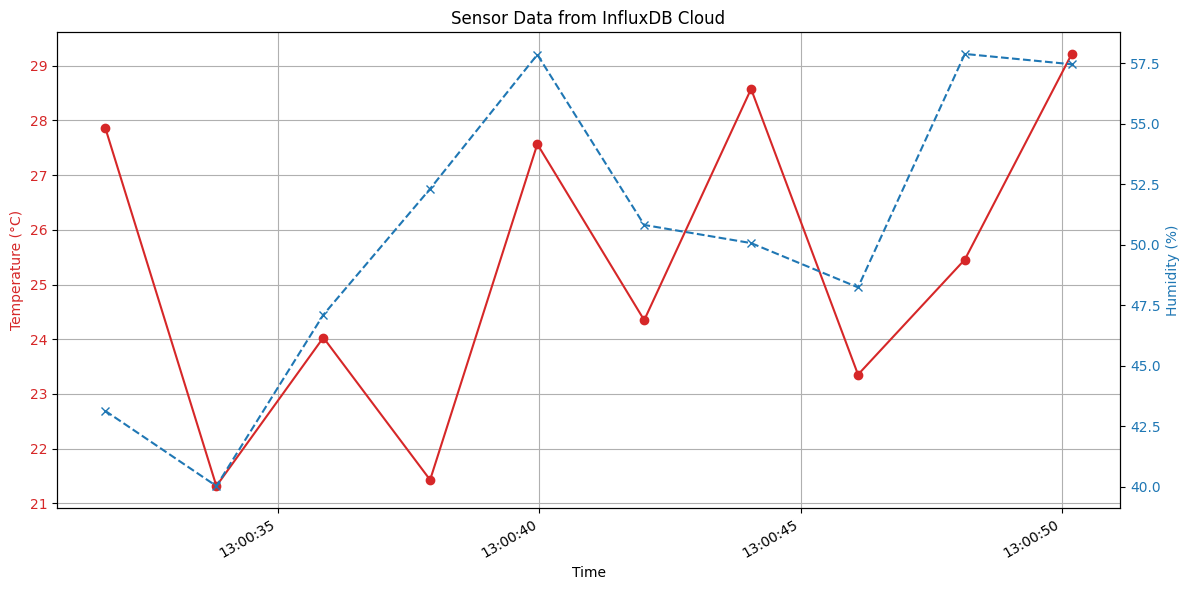

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

if 'result_df' in locals() and not result_df.empty:
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature (°C)', color=color)
    ax1.plot(result_df.index, result_df['temperature'], color=color, marker='o', linestyle='-')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True)

    # Create a second Y-axis for humidity
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Humidity (%)', color=color)
    ax2.plot(result_df.index, result_df['humidity'], color=color, marker='x', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)

    # Format the X-axis for time display
    fig.autofmt_xdate()
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.title('Sensor Data from InfluxDB Cloud')
    fig.tight_layout()  # Adjust layout
    plt.show()
else:
    print("No data available to plot.")

## **3.2 Using  Plotly**

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

if 'result_df' in locals() and not result_df.empty:
    # Create a chart with two Y axes
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add temperature line
    fig.add_trace(
        go.Scatter(x=result_df.index, y=result_df['temperature'], name="Temperature (°C)", mode='lines+markers'),
        secondary_y=False,
    )

    # Add humidity line
    fig.add_trace(
        go.Scatter(x=result_df.index, y=result_df['humidity'], name="Humidity (%)", mode='lines+markers'),
        secondary_y=True,
    )

    # Update layout
    fig.update_layout(
        title_text="Sensor Data from InfluxDB Cloud (Plotly)",
        xaxis_title="Time"
    )

    # Update Y axis labels
    fig.update_yaxes(title_text="<b>Temperature (°C)</b>", secondary_y=False)
    fig.update_yaxes(title_text="<b>Humidity (%)</b>", secondary_y=True)

    fig.show()
else:
    print("No data available to plot.")

# **4. Performance Evaluation of TSDB vs RDBMS:**

In [ ]:
import sqlite3, time

conn = sqlite3.connect('sensor.sqlite')
cursor = conn.cursor()
cursor.execute('''CREATE TABLE IF NOT EXISTS sensor_data (
    time TEXT, temperature REAL, humidity REAL, location TEXT
)''')

start = time.time()
for i in range(10000):
    cursor.execute("INSERT INTO sensor_data VALUES (?,?,?,?)",
        (datetime.utcnow(), random.uniform(20,30), random.uniform(40,60), "lab"))
conn.commit()
print("SQLite insert time:", time.time() - start)

SQLite insert time: 0.1656496524810791


In [ ]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
import time, random
from datetime import datetime

# Configure InfluxDB information
INFLUX_URL = "https://us-east-1-1.aws.cloud2.influxdata.com"
INFLUX_TOKEN = "hRguq4m3jV2rpfZKrI4hEEtzDrT2Xp2q7xo8M46f363btjhSTB_Q7jpThKtXwf-4X4t6aC8zWkZzFMISf3jifw=="
INFLUX_ORG = "University of Information Technology - UIT"
INFLUX_BUCKET = "TSBD"

client = InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)
write_api = client.write_api(write_options=SYNCHRONOUS)

for i in range(5):
    point = (
        Point("sensor_data")
        .tag("location", "lab")
        .field("temperature", random.uniform(20, 30))
        .field("humidity", random.uniform(40, 60))
        .time(datetime.utcnow())
    )
    write_api.write(bucket=INFLUX_BUCKET, org=INFLUX_ORG, record=point)
    time.sleep(1)

client.close()

start = time.time()
# InfluxDB write loop
print("InfluxDB insert time:", time.time() - start)



InfluxDB insert time: 6.628036499023438e-05
